# DESeq Workshop 1 -  Standard Analyses for RNA-seq Data (unsupervised)


# Abstract

This workshop introduces RNA-seq analysis using R, including the (Ranged)SummarizedExperiment data class, exploratory data analysis and visualizations, data transformations, and querying biomaRt for annotation information.

This workshop uses quotes and materials from [RNA-seq workflow: gene-level exploratory analysis and differential expression](https://www.bioconductor.org/help/workflows/rnaseqGene/) by Love, Anders, Kim, and Huber. The notebook is forked and modified from [two notebooks originally created by Levi Waldron](https://github.com/compbiocore/bioconductor-workshop-2). Additional workshops will further address differential expression analyses, 
# Outline

1. Introduction to RNA-seq Data
    * What is RNAseq?
        * Some more resources about sequencing technologies
    * Computational workflow overview
2. Standard data types
    * Counts matrices
    * SummarizedExperiment
        * Creating a SummarizedExperiment object from scratch
3. Exploring the Airway dataset
    * Creating a DESeqDataSet
    * Filtering genes not satisfying a minimum expression threshold
    * Data transformation
    * Exploring data at the sample level
        * Boxplots
        * Correlation plots
        * Density plots
        * Sample distances
        * PCA
        * MDS
4. Using biomaRt


#  Introduction to RNAseq

## What is RNAseq?

The central dogma of biology refers to the concept that in general, biological information flows from DNA to RNA to proteins, which are the molecules that encode for various enzymes etc., that help a living organism maintain homeostasis and self-regulate. For this workshop, we are going to talk about analyzing transcriptome data, where genes are regulated at the level of DNA being transcribed into RNA.

The general experimental process involves extracting RNA from your different experimental conditions, performing the library preparation steps (e.g., cDNA synthesis, fragmentation, and adding adapters). These libraries are sequenced on an Illumina FlowCell. The output from this process is these raw reads (.fastq or .fq files), which you can then align to the appropriate reference genome or transcriptome, where more reads will align to more highly expressed genes. This data can be processed to get back a counts matrix which will let you look at differential expression and perform other downstream analyses.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Journal.pcbi.1004393.g002.png/2560px-Journal.pcbi.1004393.g002.png">

### Some more resources about sequencing technologies:
+ https://www.illumina.com/content/dam/illumina-marketing/documents/products/illumina_sequencing_introduction.pdf      
+ Rory Stark, Marta Grezlak, and James Hadfield. NA sequencing: the teenage years Nature Reviews Genetics *Nature Reviews Genetics* **20,** 631-656 (2019)      

## Computational workflow overview

The computational analysis of an RNA-seq experiment begins from the raw FASTQ files that contain the nucleotide sequence of each read and a quality score at each position. These reads are **aligned** to a reference genome and the alignment files (.SAM or .BAM file) are turned into a counts matrix by programs such as HTSeq or featureCounts. Some newer and very fast alignment-free approaches can also estimate counts per transcript **without alignment**. Instead of directly aligning RNA-seq reads to a reference genome, they perform "pseudo-alignment" by assigning reads to transcripts that contain compatible k-mers and generate a table of read counts without the need for a counting step.

<img src="images/rnaseq_workflow.png">

There are many different programs for running alignment-based quantification. Each alignment program will make different assumptions about the data and will show some variation in performance. For example, not all aligners are 'splice-aware', which means that they will recognize intron-sized gaps that are spliced from transcripts. Some popular alignment-based tools include [STAR](https://github.com/alexdobin/STAR), [HISAT2](https://daehwankimlab.github.io/hisat2/), [GSNAP/GMAP](http://research-pub.gene.com/gmap/), among many others. Counts can be generated from SAM/BAM alignments using programs such as [featureCounts](http://bioinf.wehi.edu.au/featureCounts/) or [HTSeq](https://htseq.readthedocs.io/en/master/). 

<div class="alert alert-block alert-info"><b>Note:</b> The information you get back from directly aligning RNAseq reads to a genome will be dependent on the quality of the annotations, which are not always great (especially for non-model organisms). </div>

Alignment-free tools have gained popularity for their fast performance and low memory requirements while maintaining good accuracy.  The most popular of these tools are [Salmon](https://combine-lab.github.io) and [Kallisto](https://pachterlab.github.io/kallisto/). 

The differential expression analyses introduced here assume you are analyzing a raw counts table, where the rows are the genes or transcripts and the columns are your samples. It is always a good idea to read the documentation for any of these programs to make sure you understand what file formats should be used. The two most popular programs for  differential expression analyses are probably [DESeq2](http://bioconductor.org/packages/DESeq2) and [edgeR](http://bioconductor.org/packages/). Each program makes different assumptions and has different approaches to normalizing the data, and they will likely give you slightly different numbers of differentially expressed genes if you run both programs. 

The counts matrices can also be transformed so that they are compatible with common statistical methods for exploratory analysis of multidimensional data, for example clustering and principal components analysis (PCA), which work best for data that have the same variance at different mean values, i.e. the mean and variance are independent.

<div class="alert alert-block alert-info"><b>Note:</b> The rest of this workshop assumes you are starting with the output of some sequence analysis pipeline (i.e. counts). </div> 


# Standard data types

## Counts matrices
The counts matrix is a simple, standard way to represent RNAseq experiments. The rows correspond to genes, the columns correspond to each sample, and the data are the counts.

<img src="images/counts_matrix.png" width="300">
 
## SummarizedExperiment

The SummarizedExperiment is a data class for representing RNA-seq data. It builds on a simple counts matrix to include information about samples. It can also optionally include information about exons and genes, the experimental design, and additional metadata.

**The component parts of a *SummarizedExperiment* object `se` are:** 

* `assay(se)` or `assays(se)$counts` contains the matrix of counts
* `colData(se)` may contain data about the columns, e.g. patients or biological units
* `rowData(se)` may contain data about the rows, e.g. genes or transcript
* `rowRanges(se)` may contain genomic ranges for the genes/transcripts
* `metadata(se)` may contain information about the experiment

<img src="images/summarizedexperiment.png">

Load the `airway`,  `SummarizedExperiment`, and other packages we will need.

In [1]:
suppressPackageStartupMessages(library(airway))
suppressPackageStartupMessages(library(SummarizedExperiment))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(vsn))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(PoiClaClu))

For the purposes of this tutorial, we will be using the `airway` data. This data is in the `airway` package, stored as a `RangedSummarizedExperiment` object -- a type of `SummarizedExperiment`. Four human airway smooth muscle cell lines were left untreated or treatreated with dexamethasone for 18 hours (Himes et al. 2014).

In [2]:
data(airway)
airway

class: RangedSummarizedExperiment 
dim: 64102 8 
metadata(1): ''
assays(1): counts
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(9): SampleName cell ... Sample BioSample

Use the `assays` function to see the names of the assays stored in the object.

In [3]:
assays(airway)

List of length 1
names(1): counts

We can use the `$` accessor to view the `counts` assay. We will combine that with `head` and `assay` functions to access the first view rows of the counts matrix. The rows are genes, the columns are the samples, and the data are the counts:

In [4]:
head(assays(airway)$counts)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229
ENSG00000000460,60,55,40,35,78,63,76,60
ENSG00000000938,0,0,2,0,1,0,0,0


Use the `colData` function to see more information about each sample:

In [5]:
head(colData(airway))

DataFrame with 6 rows and 9 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862  N61311     untrt    untrt SRR1039508       126
SRR1039509 GSM1275863  N61311     trt      untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611    trt      untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611    trt      untrt SRR1039517       126
           Experiment    Sample    BioSample
             <factor>  <factor>     <factor>
SRR1039508  SRX384345 SRS508568 SAMN02422669
SRR1039509  SRX384346 SRS508567 SAMN02422675
SRR1039512  SRX384349 SRS508571 SAMN02422678
SRR1039513  SRX384350 SRS508572 SAMN02422670
SRR1039516  SRX384353 SRS508575 SAMN02422682
SRR1039517  SRX384354 SRS508576 SAMN02422673

You can use the `$` accessor to access the individual columns (like you would with a data frame).

In [6]:
levels(colData(airway)$dex)

[1] "trt"   "untrt"

### Creating a SummarizedExperiment object from scratch

You can create `SummarizedExperiment` objects using the `SummarizedExperiment` function. The `assay` and `colData` arguments are required. 

In [7]:
airway_counts <- assay(airway)
airway_samples <- colData(airway)
new_se <- SummarizedExperiment(assays = airway_counts, 
                               colData = airway_samples)
new_se

class: SummarizedExperiment 
dim: 64102 8 
metadata(0):
assays(1): ''
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(9): SampleName cell ... Sample BioSample

Use `?` to get more information about the function:

In [8]:
?SummarizedExperiment

<div class="alert alert-block alert-success"><b>Exercise 1:</b> Based on what we have just discussed, how would you create a new SummarizedExperiment object that contains information about the genes in the airway data (e.g., the rows) and their location in the genome? What about additional metadata? </div>

# Exploring the airway dataset

Exploratory data analysis of RNAseq data is an important step for assessing data quality. You can look at the expression of genes of interest or relationships/similarities among sample groupings. Filtering and exploring your data is an iterative process; as you explore and visualize your data you can tweak your filtering parameters to see how the filtering impacts the results.

## Creating a `DESeqDataSet`

Once we have our fully annotated *SummarizedExperiment* object,
we can construct a *DESeqDataSet* object from it that will then form
the starting point of the exploratory analysis. Here, `~ cell + dex` means that we are concerned with two covariates, the cell line (`cell`) and whether or not the samples were treated with dexamethasone (`dex`). 

In [9]:
dds <- DESeqDataSet(airway, design = ~ cell + dex)

We can look at the factor levels of our dex treatments:

In [10]:
levels(colData(dds)$dex)

[1] "trt"   "untrt"

We can set `untrt` as the reference factor level using `relevel`

In [11]:
colData(dds)$dex <- relevel(colData(dds)$dex, ref = "untrt")

In [12]:
levels(colData(dds)$dex)

[1] "untrt" "trt"

We can also set all the factor levels more explicitly using `factor`  

In [13]:
colData(dds)$dex  <- factor(colData(dds)$dex, levels = c("untrt","trt"))

In [14]:
levels(colData(dds)$dex)

[1] "untrt" "trt"

## Filtering genes not satisfying a minimum expression threshold

Our count matrix might contain rows with only zeroes or genes that are very lowly expressed in every condition tested. These genes are not likely to be informative, so to reduce the size of the object we can remove these rows.
Here, we remove rows of the *DESeqDataSet* that
have no counts, or only a single count across **all** samples. First, we can use `nrow` to see how many genes are in the dataset before we filter:


In [15]:
nrow(dds)

[1] 64102

Let's re-assign `dds` to `dds.original` before we do any filtering.

In [16]:
dds.original <- dds

Look at the first few lines using `head`

In [17]:
head(counts(dds.original))

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229
ENSG00000000460,60,55,40,35,78,63,76,60
ENSG00000000938,0,0,2,0,1,0,0,0


Let's filter the expression matrix so we are including genes that have at least one fragment mapped in at least 1 sample (or `rowSums` greater than 1).

In [18]:
dds <- dds[ rowSums(counts(dds)) > 1, ]

Let's look at the first few rows:

In [19]:
head(counts(dds))

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229
ENSG00000000460,60,55,40,35,78,63,76,60
ENSG00000000938,0,0,2,0,1,0,0,0
ENSG00000000971,3251,3679,6177,4252,6721,11027,5176,7995


Notice that the gene that had zero counts in every sample (`ENSG00000000005`) is gone, but `ENSG00000000938` remains because it has a rowSum greater than 1. How many genes do we have left after filtering?

In [20]:
nrow(dds)

[1] 29391

Only 46% of the genes remain after performing this filtering step. A more stringent method of filtering, such as removing all genes that have any 0 count entries at all, would yield an even smaller percentage of genes. Let's look at the count densities from before and after filtering:

First, we can use the `gather` function to turn our data into a longer format.

In [21]:
counts_melted_original <- gather(as.data.frame(counts(dds.original)), 
                                 key = 'library', 
                                 value = 'counts', 
                                 SRR1039508:SRR1039521)

counts_melted_filtered <- gather(as.data.frame(counts(dds)), 
                                 key = 'library', 
                                 value = 'counts', 
                                 SRR1039508:SRR1039521)

Then we can compare the density plots:

Warning message:
“Removed 74557 rows containing non-finite values (stat_density).”
Warning message:
“Removed 74557 rows containing non-finite values (stat_density).”


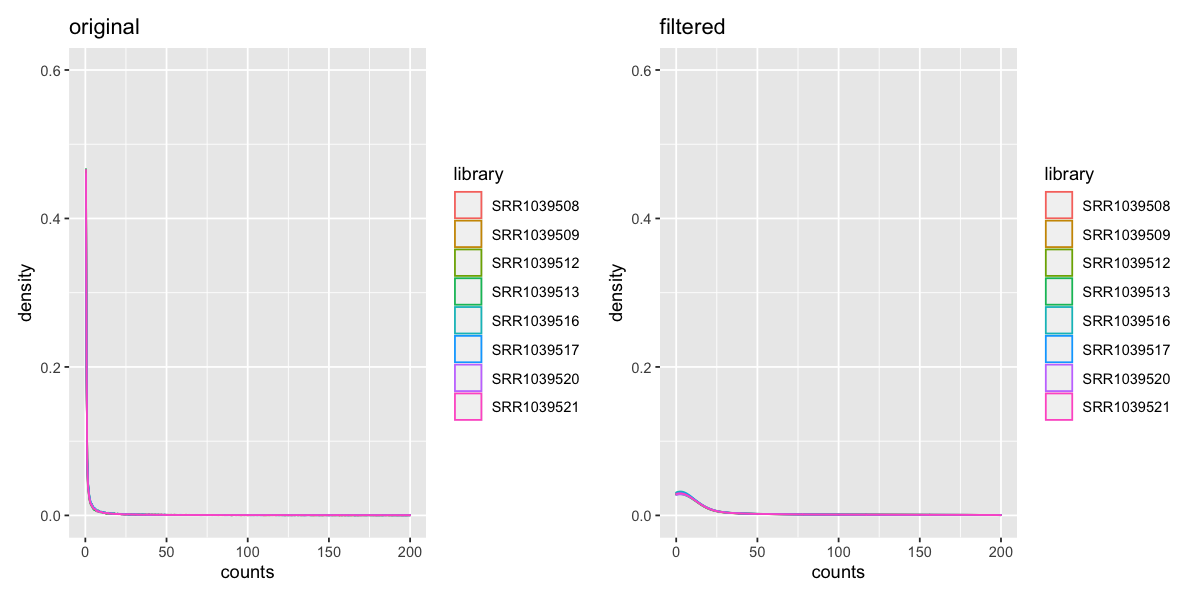

In [22]:
p1 <- ggplot(counts_melted_original, aes(x = counts)) + 
geom_density(aes(group = library, color = library), adjust = 5) + 
xlim(0, 200) + 
ylim(0, .6) +
ggtitle('original')


p2 <- ggplot(counts_melted_filtered, aes(x = counts)) + 
geom_density(aes(group = library, color = library), adjust = 5) + 
xlim(0, 200) + 
ylim(0, .6) + 
ggtitle('filtered')


options(repr.plot.height=5, repr.plot.width=10)
p1 | p2


The warning message just means that there are some data points that are not displayed because they are not within the axis ranges we have defined. We can see that our filtering has shifted our density plots -- before filtering nearly all of the area under the curve was near 0. These genes do not contribute meaningful information to our analysis (and can even bias some of our analytical techniques) so we remove them.

**Note**: For differential expression analysis later, filtering is 
allowable but not necessary if using [Independent Hypothesis Weighting](http://www.bioconductor.org/packages/IHW),
as is the default behavior of `DESeq2`. Independent hypothesis weighting (IHW) is a multiple testing procedure that increases power compared to the method of Benjamini and Hochberg by assigning data-driven weights to each hypothesis.

<div class="alert alert-block alert-success"><b>Exercise 2:</b> How many genes pass a different filtering cutoff where at least 3 samples must have a count of 10 or higher? How does this filtering change the density plots? </div>


## Data Transformation

Why transform the data? Many common statistical methods for *exploratory* analysis of
multidimensional data, for example clustering and *principal
components analysis* (PCA), **work best for data that generally has the
same variance across different values of the mean**. When
the expected amount of variance is approximately the same across
different mean values, the data is said to be *homoskedastic*.      

For RNA-seq count data, however, the expected variance grows with the mean. The problem with this mean-variance relationship is that **if one performs PCA directly on a matrix of counts or normalized counts (e.g. correcting for differences in sequencing depth), the resulting plot typically depends mostly on the genes with the *highest* counts because they show the largest absolute differences between samples**. Simply put, the genes with the highest counts (i.e., those that are more highly expressed) will dominate the analysis simply due to them having more variability.      

A simple and often used strategy to address this problem is to take the logarithm of the normalized
count values plus a pseudocount of 1 (this pseudocount of 1 accounts for 0-count observations, as the log of 0 is undefined and the log of 1 is always 0, irrespective of base); however, this approach can also introduce problems; depending on the choice of pseudocount, the genes with **the very *lowest* counts
will now contribute a great deal of noise to the resulting plot, because
taking the logarithm of small counts actually inflates their variance**.     

As a solution, DESeq2 offers two additional transformations for count data that stabilize the variance across the mean: the **regularized-logarithm transformation or rlog** (Love, Huber, Anders, Genome Biology 2014); and the **variance stabilizing transformation or VST** for negative binomial data with a dispersion-mean trend (Anders and Huber, Genome Biology 2010).

Let's compare these different transformation methods. First, we will run the `rlog` and `vst` transformations.

In [23]:
rld <- rlog(dds, blind = FALSE) #rlog
vsd <- vst(dds, blind = FALSE) #vst

We will also run the standard `log2` transformation, where a pseudocount of 1 is added to each point before transforming. We need to first estimate *size factors* to
account for sequencing depth, and then specify `normalized=TRUE`.
Sequencing depth correction is done automatically for the `rlog`
and the `vst`.

In [24]:
ddsESF <- estimateSizeFactors(dds) #estimate size factors first
logt <- data.frame(log2(counts(ddsESF, normalized=TRUE)[, 1:2] + 1)) #standard log2

Now we can look at some scatter plots to compare the raw counts to the three different transformation methods:

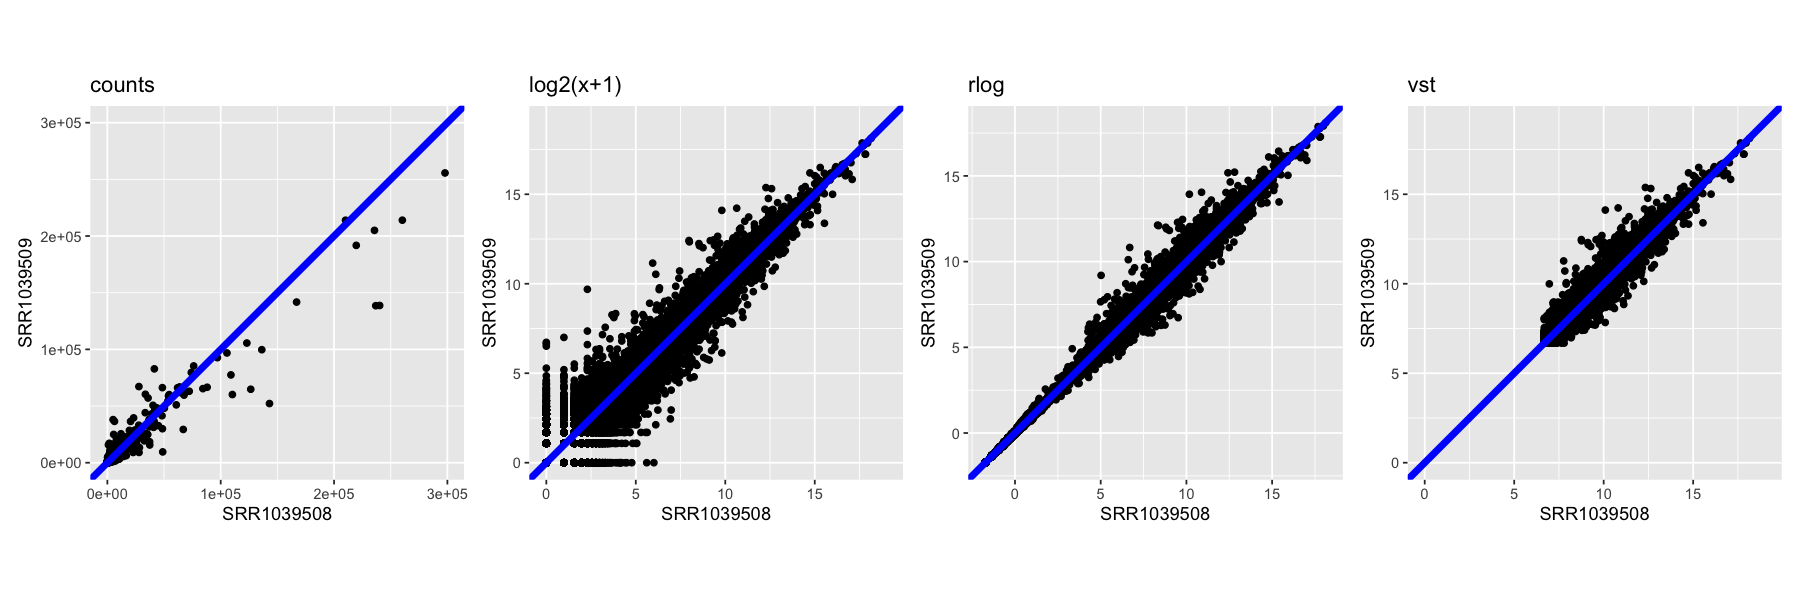

In [25]:
p1 <- ggplot(data.frame(assay(dds)[, 1:2]), aes(x = SRR1039508, y = SRR1039509)) + 
geom_point() + 
geom_abline(intercept = 0, slope = 1, color = 'blue', size = 2) +
coord_fixed() +
xlim(0,300000)+
ylim(0,300000) +
ggtitle('counts')

p2 <- ggplot(logt, aes(x = SRR1039508, y = SRR1039509)) + 
geom_point() + 
geom_abline(intercept = 0, slope = 1, color = 'blue', size = 2) +
coord_fixed() +
xlim(0,19)+
ylim(0,19) +
ggtitle('log2(x+1)')

p3 <- ggplot(data.frame(assay(rld)[, 1:2]), aes(x = SRR1039508, y = SRR1039509)) + 
geom_point() + 
geom_abline(intercept = 0, slope = 1, color = 'blue', size = 2) +
coord_fixed() +
ggtitle('rlog')

p4 <- ggplot(data.frame(assay(vsd)[, 1:2]), aes(x = SRR1039508, y = SRR1039509)) + 
geom_point() + 
geom_abline(intercept = 0, slope = 1, color = 'blue', size = 2) +
coord_fixed() +
xlim(0,19)+
ylim(0,19) +
ggtitle('vst')

options(repr.plot.width=15, repr.plot.height=5)

p1 | p2 | p3 | p4

Here are some scatter plots showing the raw counts and the log2 (left), rlog (middle), and VST (right) transformed counts. The x and y axes are expression values in two samples from the `airway` data. Each black dot is a gene and its position on the plot indicates its expression levels in two of the `airway` data samples. The blue line is indicating the 1:1 line -- points closer to this line have similar expression values in sample x and in sample y. Genes in the bottom left corner are lowly expressed and genes in the upper right corner are highly expressed.    

We can see how genes with low counts (bottom left-hand corner) are highly variable on the ordinary logarithmic scale (`log2`), while the `rlog` transform and `vst` compress differences for the low count genes. Since these low-count values are likely artifacts introduced by sequencing error or random chance, their exclusion helps to prevent false positives.  

Plotting the standard deviation of each row (gene) against the mean is also helpful for understanding how data transformations impact the mean:variance relationship:

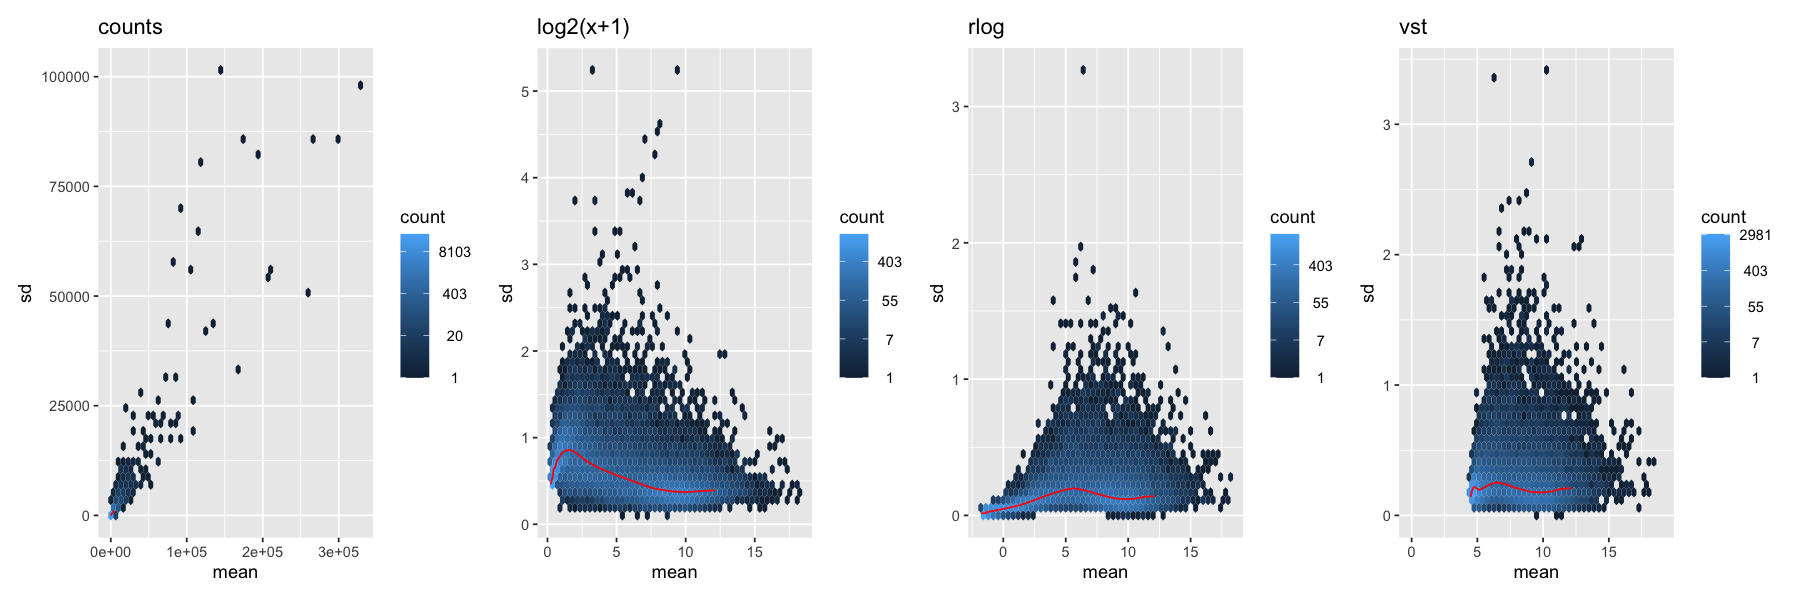

In [26]:
p5 <- meanSdPlot(counts(dds), ranks = FALSE, plot = FALSE)
p6 <- meanSdPlot((log2(counts(ddsESF) + 1)), ranks = FALSE, plot = FALSE)
p7 <- meanSdPlot(rlog(counts(dds)), ranks = FALSE, plot = FALSE)
p8 <- meanSdPlot(vst(counts(dds), blind = FALSE), ranks = FALSE, plot = FALSE)

p5$gg + ggtitle('counts')| p6$gg + ggtitle('log2(x+1)') | p7$gg + ggtitle('rlog') | p8$gg + ggtitle('vst')  + scale_x_continuous(limits = c(0, 19))  

On each of these plots, the x-axis is the mean and the y-axis is the standard deviation. The color of each point indicates how many data points have a given mean and standard deviation. Ligher blue colors indicate a greater number of data points at a particular mean and standard deviation, while darker blue indicates fewer data points.

If we look at the `counts` plot on the far left, we see outliers in the upper right of the plot, each colored dark blue to show that very few genes fall within each point - these observations would cause a great deal of bias in the results if uncorrected.

Moving to the `log2` plot, we see that transforming our data using the logarithm with a small pseudocount transformation (i.e., the standard log2 transformation) amplifies the standard deviation when the
values are close to 0. As a result, the low count genes with low signal-to-noise
ratio will now overly contribute to sample-sample distances and PCA
plots.  

For genes with high counts, the rlog and VST transformations will give results similar
to that of the ordinary log2 transformation of normalized counts. **For genes
with lower counts, the values are shrunken towards the genes'
averages across all samples**. The rlog-transformed or VST data then
becomes approximately homoskedastic, and can be used directly for
computing distances between samples, making PCA plots, or as input to
downstream methods which perform best with homoskedastic data.

**Which transformation to choose?** The **rlog tends to work well on
small datasets (n < 30)**, sometimes outperforming the VST when there is
a large range of sequencing depth across samples (an order of
magnitude difference). However, the VST is much faster to compute and is less
sensitive to high count outliers than the rlog. Therefore, **we recommend
the VST for large datasets (hundreds of samples)**. You can perform both
transformations and compare the `meanSdPlot` or PCA plots generated.

<div class="alert alert-block alert-warning"><b>Note:</b> Using transformed or normalized counts is only for visualizing and exploring data -- statistical analysis packages like DESeq2 and edgeR should be used with raw counts matrices </div>

In the above function calls, we specified `blind = FALSE`, which means
that differences between cell lines and treatment (the variables in
the design) will not contribute to the expected variance-mean trend of
the experiment. The experimental design is not used directly in the
transformation, only in estimating the global amount of variability in
the counts.  For a fully *unsupervised* transformation, one can set
`blind = TRUE` (which is the default).

## Exploring data at the sample level

A useful step in an RNA-seq analysis is often to assess overall similarity between samples: Which samples are similar to each other, which are different? Does this fit to the expectation from the experiment's design?

Before we get started, tidy the counts and transformed counts matrices so they are easier to visualize:

In [27]:
log2_tidy <- gather(as.data.frame(log2(assay(ddsESF)+1)), 
        key = 'library', 
        value = 'counts', 
        SRR1039508:SRR1039521)

rld_tidy <- gather(as.data.frame((assay(rld))), 
        key = 'library', 
        value = 'counts', 
        SRR1039508:SRR1039521)

vsd_tidy <- gather(as.data.frame((assay(vsd))), 
        key = 'library', 
        value = 'counts', 
        SRR1039508:SRR1039521)

### Boxplots

Boxplots of the count distributions in each sample are a good way to understand the effects these transformations have at the level of individual subjects.

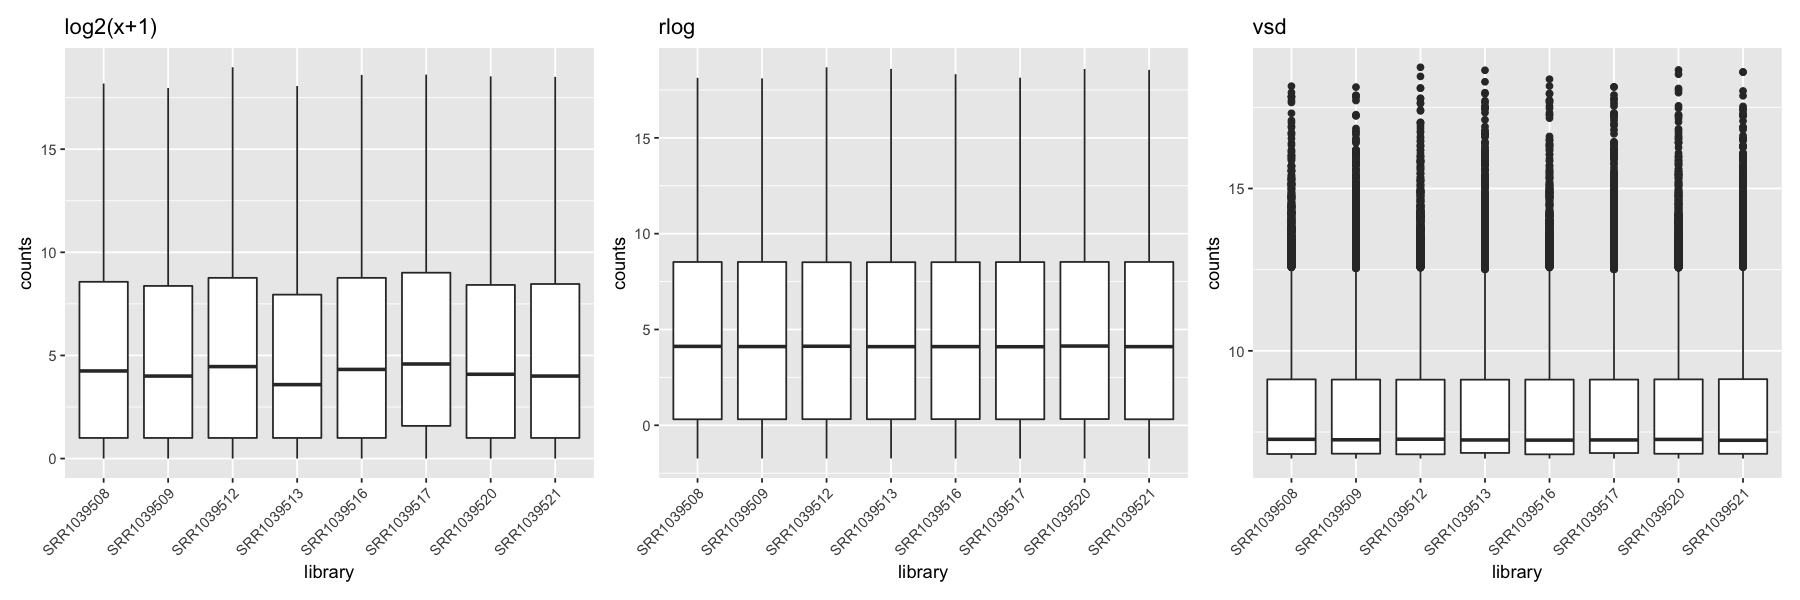

In [28]:
bp1 <- ggplot(log2_tidy, aes(x = library, y = counts)) + 
geom_boxplot() +
ggtitle('log2(x+1)') +
theme(axis.text.x = element_text(angle = 45, hjust = 1))

bp2 <- ggplot(rld_tidy, aes(x = library, y = counts)) + 
geom_boxplot() +
ggtitle('rlog')+
theme(axis.text.x = element_text(angle = 45, hjust = 1))

bp3 <- ggplot(vsd_tidy, aes(x = library, y = counts)) + 
geom_boxplot() +
ggtitle('vsd')+
theme(axis.text.x = element_text(angle = 45, hjust = 1))

options(repr.plot.width=15, repr.plot.height=5)

bp1 | bp2 | bp3

In R's boxplots, points classified as outliers are shown on the plots as circles. Neither the standard log2 or the rlog transformations include any outliers, while the vst transformations do have outliers at the upper end of the distributions.  These points are classified as outliers because the vst method compresses lower end points more substantially (which can be seen on the scatter plots above). The actual magnitude of these points does not significantly exceed the magnitude seen with the other transformations.

### Density plots

Density plots are another good way to visualize if the counts distributions agree (or disagree) across the samples.

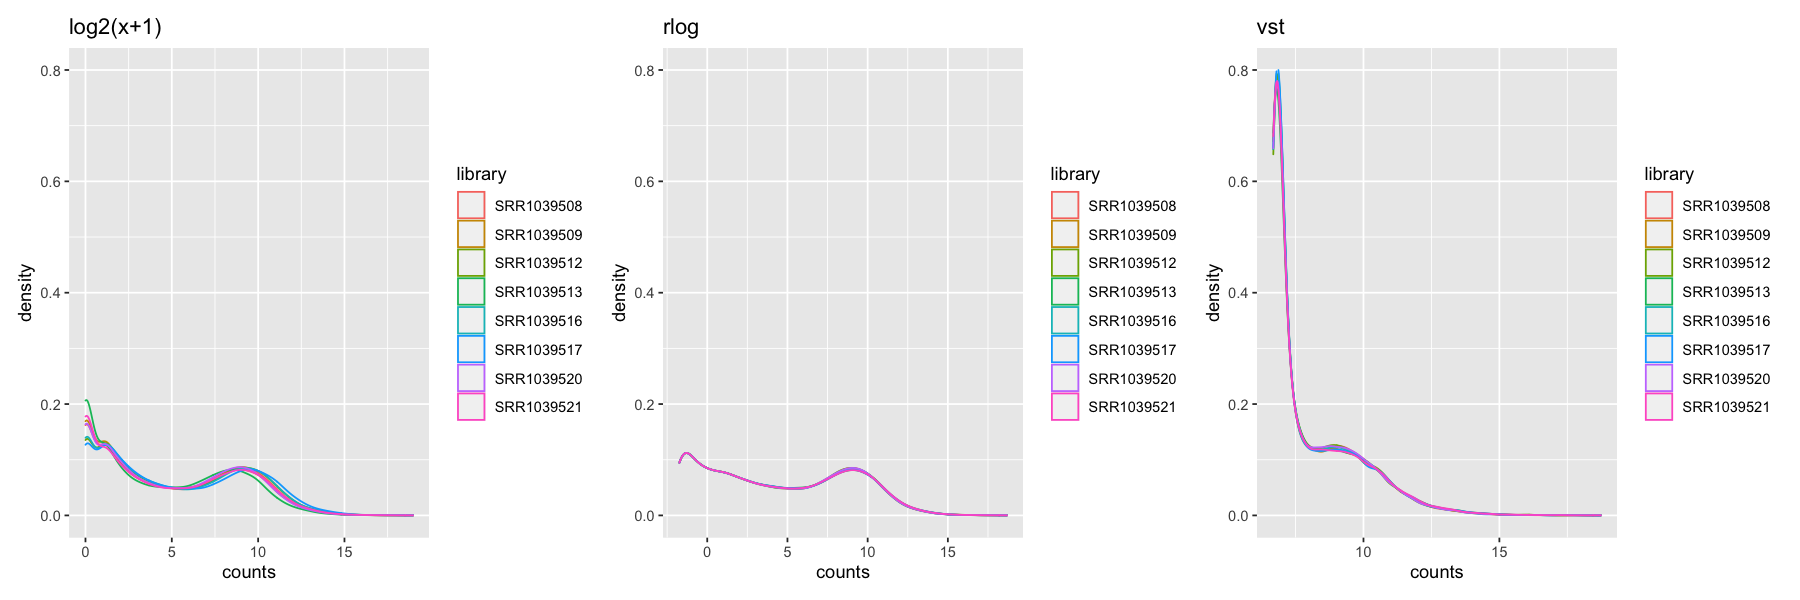

In [29]:
dp1 <- ggplot(log2_tidy, aes(x = counts, color = library)) + 
geom_density() +
ggtitle('log2(x+1)') +
ylim(0,.8)

dp2 <- ggplot(rld_tidy, aes(x = counts, color = library)) + 
geom_density() +
ggtitle('rlog') +
ylim(0,.8)

dp3 <- ggplot(vsd_tidy, aes(x = counts, color = library)) + 
geom_density() +
ggtitle('vst') +
ylim(0,.8)

dp1 | dp2 | dp3

Note the different axis scales again -- the vst transformation axes do not start at 0 because this method shifts all the low counts data toward their mean across samples. We can also see the previously discussed issues with how the log2 transformation handles low counts data. You might also notice that some of the rlog counts are below 0 -- again, this is expected as rlog borrows information across samples and implements a log transformation (which will result in negative values for counts below 1).

### Sample distances

We can also use the R function dist to calculate the "Euclidean distance" between samples; the Euclidean distance is simply the higher-dimensional analogue of the human-measurable distance between points in 2 or 3 dimensions. 

To ensure we have a roughly equal contribution from all genes, we calculate it from the rlog-transformed data. We need to transpose the matrix of values using t, because the dist function expects the different samples to be rows of its argument, and different dimensions (here, genes) to be columns.

In [30]:
sampleDists <- dist(t(assay(rld)))
sampleDists

           SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517
SRR1039509   45.70156                                                       
SRR1039512   39.25598   54.91227                                            
SRR1039513   62.63597   44.53083   48.72886                                 
SRR1039516   44.50960   59.06801   43.58240   63.74705                      
SRR1039517   64.49866   51.45301   59.23395   49.88392   47.48508           
SRR1039520   39.58025   57.46653   36.74745   58.49396   46.41177   63.60393
SRR1039521   63.36519   45.06067   57.87995   36.49798   65.55040   52.32102
           SRR1039520
SRR1039509           
SRR1039512           
SRR1039513           
SRR1039516           
SRR1039517           
SRR1039520           
SRR1039521   50.13744

Then we can make a heatmap to visualize the correlations. 

In order to plot the sample distance matrix with the rows/columns arranged by the distances in our distance matrix, we manually provide sampleDists to the clustering_distance argument of the pheatmap function. Otherwise the pheatmap function would assume that the matrix contains the data values themselves, and would calculate distances between the rows/columns of the distance matrix, which is not desired. We also manually specify a blue color palette using the colorRampPalette function from the RColorBrewer package (this coloring step is optional).

Make the sampleDists into a matrix

In [31]:
sampleDistMatrix <- as.matrix(sampleDists)
head(sampleDistMatrix)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
SRR1039508,0.00000,45.70156,39.25598,62.63597,44.50960,64.49866,39.58025,63.36519
SRR1039509,45.70156,0.00000,54.91227,44.53083,59.06801,51.45301,57.46653,45.06067
SRR1039512,39.25598,54.91227,0.00000,48.72886,43.58240,59.23395,36.74745,57.87995
SRR1039513,62.63597,44.53083,48.72886,0.00000,63.74705,49.88392,58.49396,36.49798
SRR1039516,44.50960,59.06801,43.58240,63.74705,0.00000,47.48508,46.41177,65.55040
SRR1039517,64.49866,51.45301,59.23395,49.88392,47.48508,0.00000,63.60393,52.32102


Give the rows more meaningful names and clean up the column names since they will be redundant in the heatmap

In [32]:
rownames(sampleDistMatrix) <- paste( rld$dex, rld$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
head(sampleDistMatrix)

untrt - N61311,0.00000,45.70156,39.25598,62.63597,44.50960,64.49866,39.58025,63.36519
trt - N61311,45.70156,0.00000,54.91227,44.53083,59.06801,51.45301,57.46653,45.06067
untrt - N052611,39.25598,54.91227,0.00000,48.72886,43.58240,59.23395,36.74745,57.87995
trt - N052611,62.63597,44.53083,48.72886,0.00000,63.74705,49.88392,58.49396,36.49798
untrt - N080611,44.50960,59.06801,43.58240,63.74705,0.00000,47.48508,46.41177,65.55040
trt - N080611,64.49866,51.45301,59.23395,49.88392,47.48508,0.00000,63.60393,52.32102


Let's set our color palette for the heatmap.

In [33]:
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

Now we make the heatmap, specifying that we have already calculated the clustering distances and stored them in `sampleDists`.

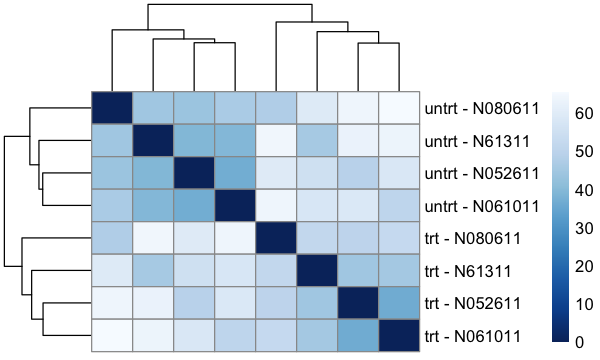

In [34]:
options(repr.plot.height=3, repr.plot.width=5)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

Another option for calculating sample distances is to use the Poisson Distance, implemented in the PoiClaClu CRAN package. This measure of dissimilarity between counts also takes the inherent variance structure of counts into consideration when calculating the distances between samples. The PoissonDistance function takes the original count matrix (not normalized) with samples as rows instead of columns, so we need to transpose the counts in dds.

In [35]:
poisd <- PoissonDistance(t(counts(ddsESF)))

convert to a matrix and fix the row and column names

In [36]:
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL

Then create the heatmap using the same color palette previously defined

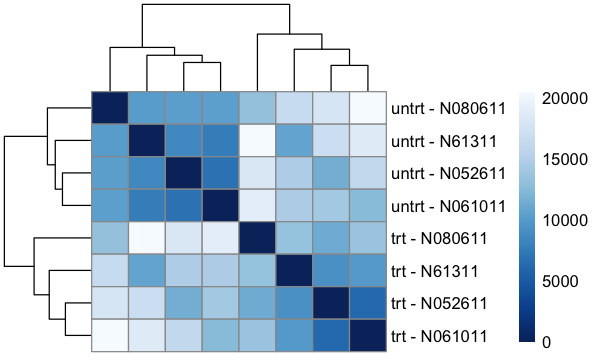

In [37]:
options(repr.plot.height=3, repr.plot.width=5)
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)

In both cases, the distance matrices are indicating that there are differences between cell types, but they generally cluster based on their treatment before cell type.

We can also use the `ggpairs` function to look at trends across samples:

In [38]:
options(repr.plot.width=10, repr.plot.height=10)

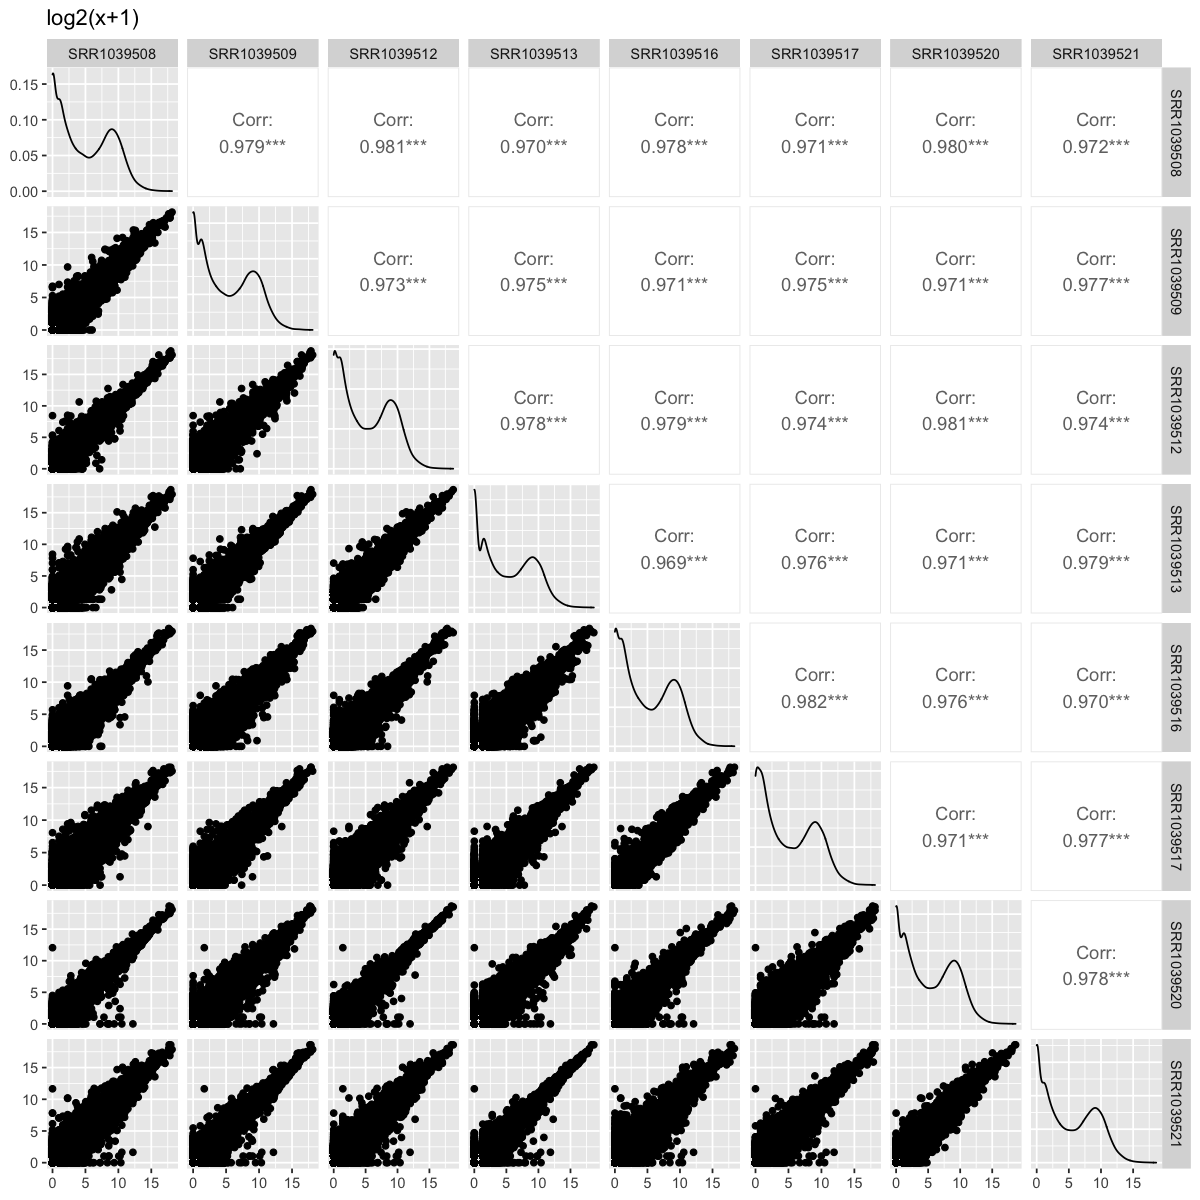

In [39]:
ggpairs(as.data.frame(log2(counts(ddsESF, normalized=TRUE) + 1)), title = 'log2(x+1)')

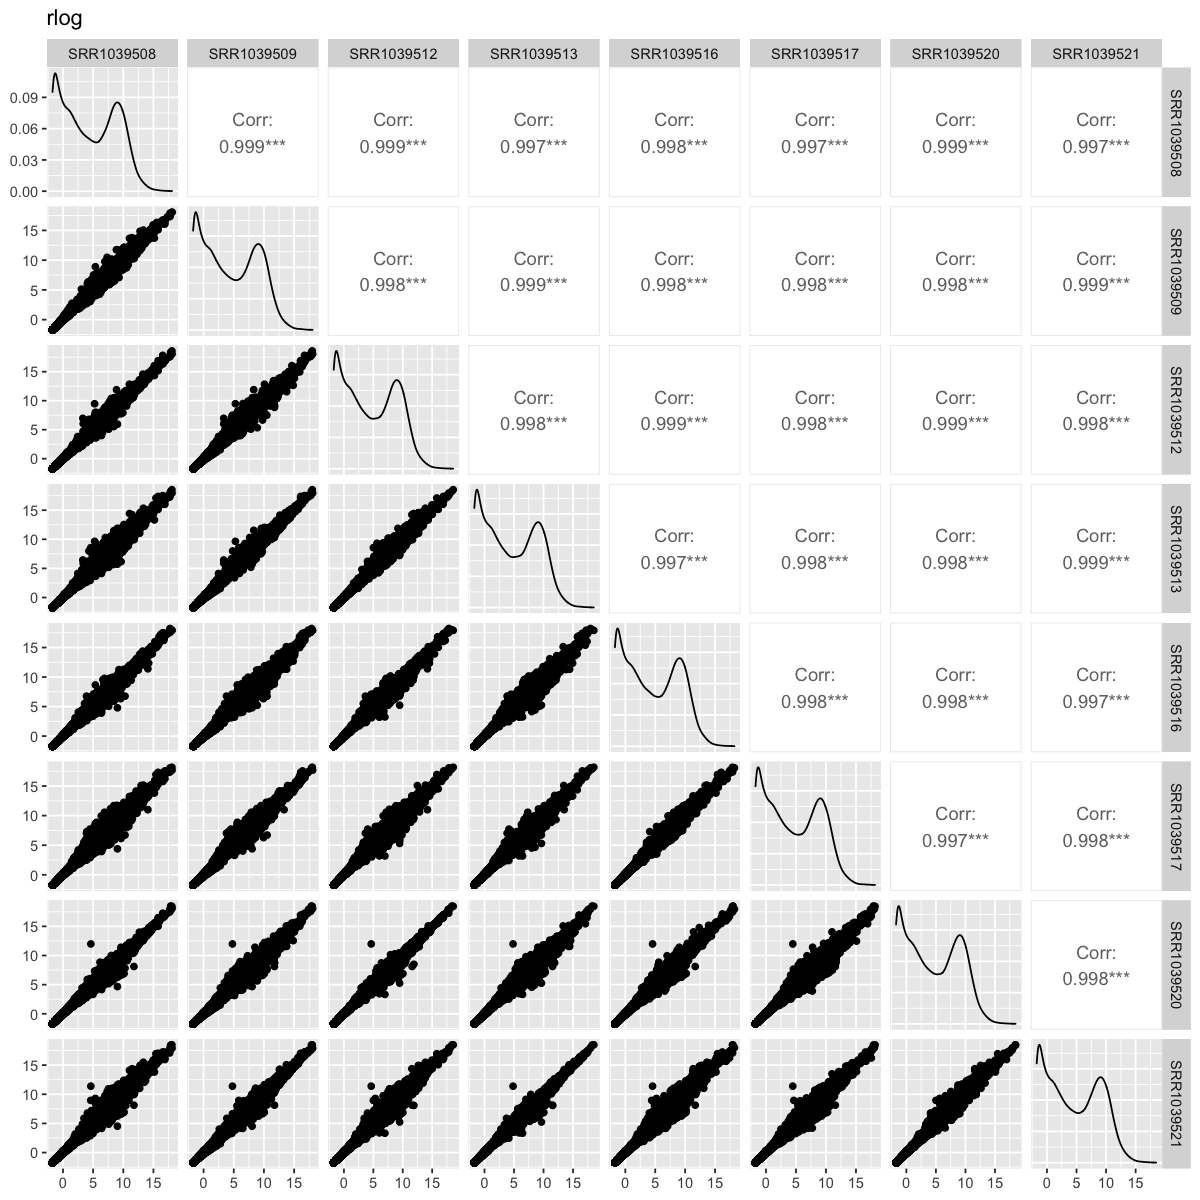

In [40]:
ggpairs(as.data.frame(rlog(counts(dds))), title = 'rlog')

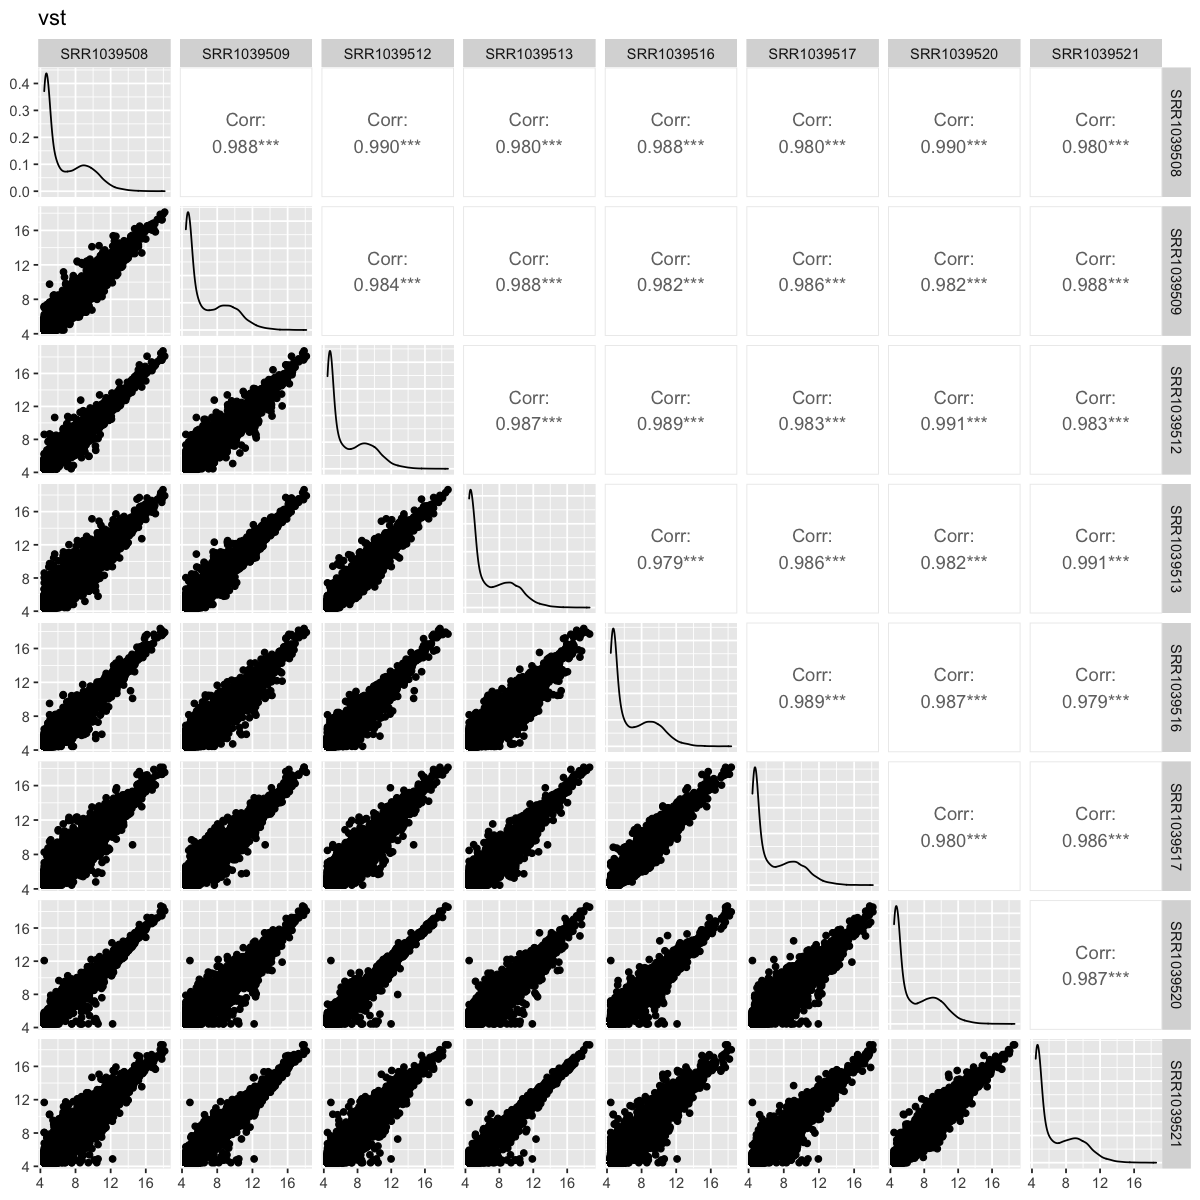

In [41]:
ggpairs(as.data.frame(vst(counts(dds))), title = 'vst')

Starting in the lower left corner of the ggpairs plot, we see several scatter plots that compare each of the samples. The scatter plots are just like the 1:1 plots shown earlier in this workshop, where each point is a gene and points that are closer to the 1:1 line show similar expression levels in the two samples compared. Again, we can see that the  log2 transformation has higher variance when the counts are closer to 0. The rlog transformation compresses the variation, while the vst transformation shifts counts away from 0 (note the axes that start at 4).   

Distribution plots are shown on the diagonal -- we can see how each of these transformations influences the distribution of the counts -- note the axis ranges on the vst plots, which do not start at 0. The scatterplots are prone to over-plotting so it can be difficult to tell how many points are in each section of the plot -- the density plots help convey that information.    

The upper right corner shows the Pearson correlations -- a concise way to make sure your samples are behaving the ways you anticipate (for example, that your replicates agree).


## PCA

Another way to visualize sample-to-sample distances is a
principal components analysis (PCA). In this ordination method, the
data points (here, the samples) are projected onto the 2D plane
such that they spread out in the two directions that explain most of
the differences (figure below). The x-axis is the direction (i.e., principal component) that separates the data
points the most. The values of the samples in this direction are
written *PC1* ("principal component 1"). The y-axis is a direction (another principal component, which must be *orthogonal* - perpendicular - to
the first direction) that separates the data the second most. The
values of the samples in this direction are written *PC2*.
The percent of the total variance that is contained in the direction
is printed in the axis label. Note that these percentages do not add to
100%, because there are more dimensions - often many of them - that contain the remaining
variance (although each of these remaining dimensions will by definition explain
less than the two that we see).

DataFrame with 8 rows and 10 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862  N61311     untrt    untrt SRR1039508       126
SRR1039509 GSM1275863  N61311     trt      untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611    trt      untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611    trt      untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011    trt      untrt SRR1039521        98
           Experiment    Sample    BioSample sizeFactor
             <factor>  <factor>     <factor>  <numeric>
SRR1039508  SRX384345 SRS508568 SAMN02422669   1.023648
SRR1039509  SRX384346 SRS508567 SAMN02422675   0.896167
SRR1039512  SRX384349 SRS508571 SAMN024

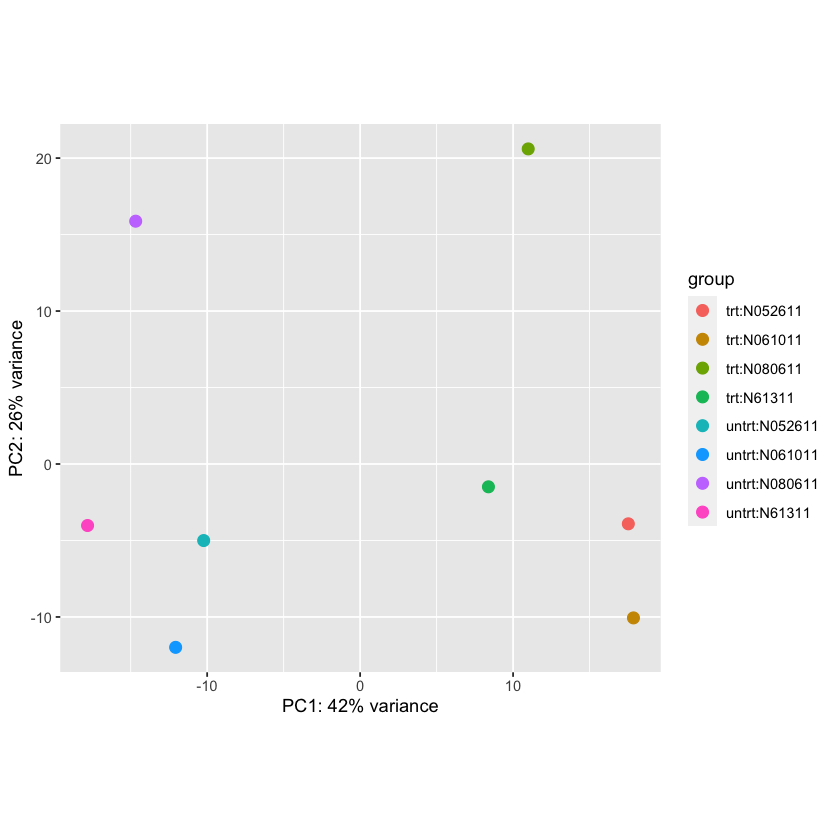

In [42]:
colData(rld)
options(repr.plot.width=7, repr.plot.height=7)
plotPCA(rld, intgroup = c("dex", "cell"))

Here, we have used the function `plotPCA()` that comes with *DESeq2* to plot the rlog transformed data.
The two terms specified by `intgroup` are the interesting groups for
labeling the samples; they tell the function to use them to choose
colors. Each unique combination of treatment and cell line is given its own color.   

<div class="alert alert-block alert-success"><b>Exercise 3:</b> If you look at `?plotPCA`, you'll see that the default behavior of `plotPCA` is to plot the top 500 genes. Does the PCA change if you change those settings and set `ntop = 50`?  </div>

We can also build the PCA plot from scratch using the
[ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html) package.
This is done by asking the `plotPCA()` function
to return the data used for plotting rather than building the plot.
See the *ggplot2* [documentation](http://docs.ggplot2.org/current/)
for more details on using `ggplot()`.

Run `plotPCA` with `returnData = TRUE`

In [43]:
pcaData <- plotPCA(rld, intgroup = c( "dex", "cell"), returnData = TRUE)
pcaData
percentVar <- round(100 * attr(pcaData, "percentVar"))
percentVar

,PC1,PC2,group,dex,cell,name
,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>
SRR1039508,-17.818475,-4.021258,untrt:N61311,untrt,N61311,SRR1039508
SRR1039509,8.388114,-1.491326,trt:N61311,trt,N61311,SRR1039509
SRR1039512,-10.227669,-5.004221,untrt:N052611,untrt,N052611,SRR1039512
SRR1039513,17.533461,-3.910086,trt:N052611,trt,N052611,SRR1039513
SRR1039516,-14.672155,15.874218,untrt:N080611,untrt,N080611,SRR1039516
SRR1039517,10.988340,20.599708,trt:N080611,trt,N080611,SRR1039517
SRR1039520,-12.060843,-11.986220,untrt:N061011,untrt,N061011,SRR1039520
SRR1039521,17.869226,-10.060814,trt:N061011,trt,N061011,SRR1039521


[1] 42 26

In [44]:
percentVar

[1] 42 26

We can then use this structure to build up a second plot in a figure below, specifying that the
color of the points should reflect dexamethasone treatment and the
shape should reflect the cell line.

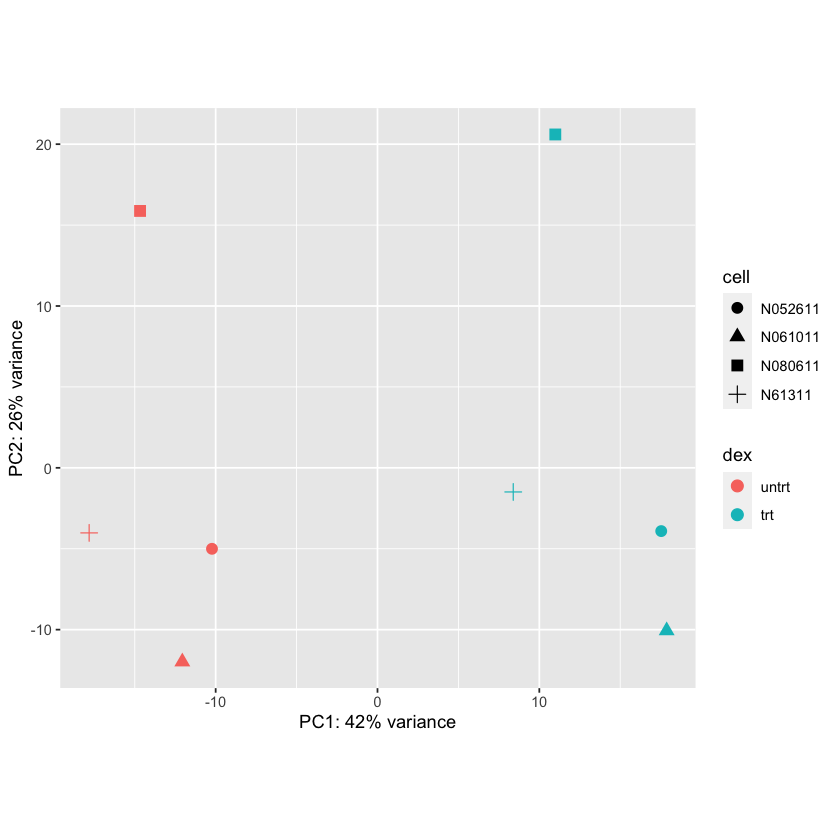

In [45]:
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()

From the PCA plot, we see that the differences between cells (the
different plotting shapes) are considerable, though not stronger than the differences due to
treatment with dexamethasone (red vs blue color). This shows why it will be important to
account for this in differential testing by using a paired design
("paired", because each dex treated sample is paired with one
untreated sample from the *same* cell line). We are already set up for
this design by assigning the formula `~ cell + dex` earlier when specifying our model.

**A note on outlier detection:** there are no hard, fast rules for identifying outliers; however, PCA can provide you with useful information for making decisions about which samples may be outliers. One general approach is to visually inspect the PCA bi-plot produced by the `plotPCA` function (i.e., the plot visualizing the samples along the two principal components explaining the most variance). Samples that are outliers will be many of orders of magnitude away from the main group of samples along principal component 1; the difference should be easy to identify visually and usually will not require statistical justification. A second approach is to quantify outliers using z-score standardization. Specifically, you take the principal component 1 values from your PCA object and convert them to z-scores using the following standardization: 

$x_{gi}$ $\leftarrow$ $\frac{(x_{gi} - \bar{x}_g)}{s_g}$  

In our context, this just means we take each value on the first principal component, subtract it from the mean of all the values on the first principal component, and then divide this difference by the standard deviation of all the values on the first principal component. To do so, we would access the first principal component from our PCA object using `pcaData$PC1` and standardize these scores using `scale(pcaData$PC1)`. Once you have the standardized scores, outliers can be identified as z-scores greater than 3 or 6 in absolute value, depending on how conservative one wishes to be.

**Note:** It is important to note that the two aforementioned approaches are just general guidelines and identification of outliers requires statistical knowledge as well as detailed knowledge of experimental details, lab techniques used, etc. It is advised that you consult with a statistician when making such decisions. 


## MDS
Another plot, very similar to the PCA plot, can be made using the 
*multidimensional scaling* (MDS) function in base R. MDS is a useful technique for examining sample-to-sample distances that is **used when we don't have the original data, but instead have only a matrix of distances**. Here we compute the MDS for the distances calculated from the *rlog*
transformed counts and plot these in a figure below.

This method, unlike PCA, does not show the percent of variance explained by the individual components.

**MDS plot using rlog-transformed values.**

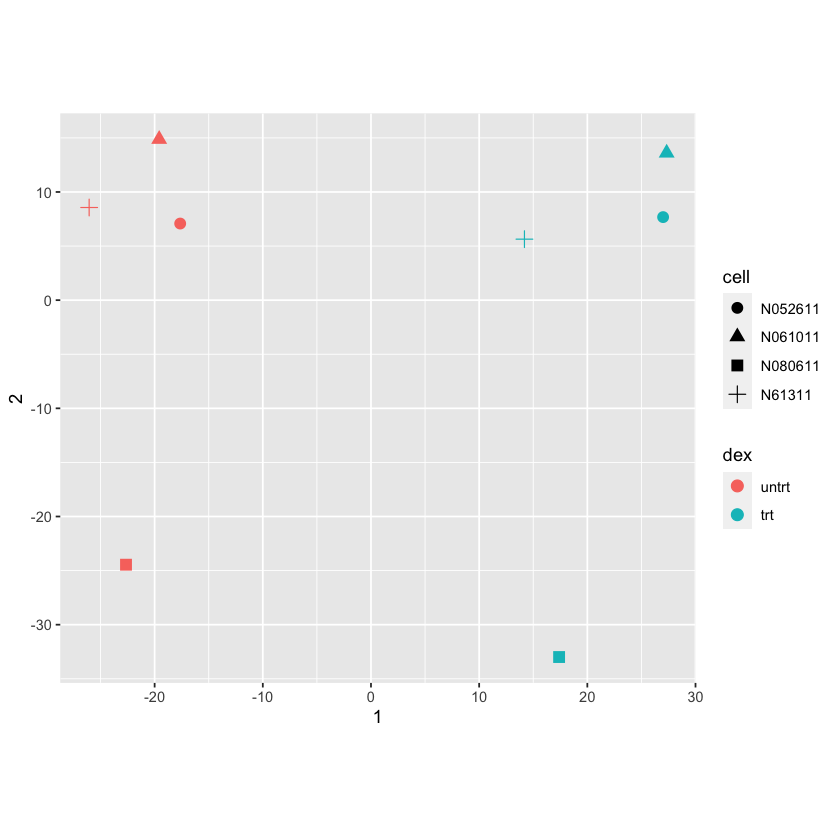

In [46]:
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix( sampleDists )
mds <- cbind(as.data.frame(colData(rld)), cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

**MDS plot using the Poisson Distance.**

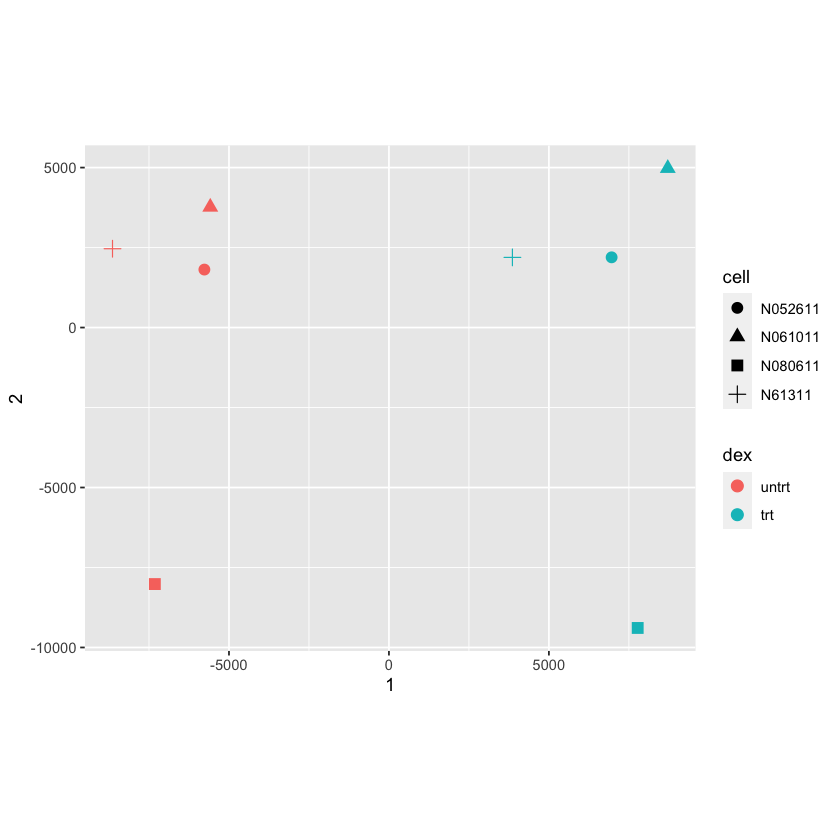

In [47]:
library(PoiClaClu)
poisd <- PoissonDistance(t(counts(ddsESF)))
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )

mdsPois <- cbind(as.data.frame(colData(ddsESF)),
   cmdscale(samplePoisDistMatrix))
ggplot(mdsPois, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()



**A key difference between PCA and MDS is that PCA preserves the covariance of the data, while MDS preserves the distance between the data points. Depending on what type of distance you use for your MDS analysis, these two results can be the same (if Euclidean distance is used) or different.  Here, we have used the Poisson distance (since it takes the structure of the variance into account), so the MDS and PCA results are not exactly the same.**

# Using biomaRt

The [biomaRt](https://bioconductor.org/packages/release/bioc/html/biomaRt.html) package makes it easy to query public repositories of biological data. We can use biomaRt to query Ensembl for annotations so that we can look for 'housekeeping genes' which are typically considered to be stably expressed and shouldn't show large variations across different samples. We have selected a list of genes based on two publications that queried public cancer genome data to find housekeeping genes for use with RNA-seq from cancer cell lines (https://doi.org/10.1186/s12859-019-2809-2, https://doi.org/10.3389/fgene.2019.00097). 

There are many other ways to retrieve annotation information, such as [AnnotationHub](https://bioconductor.org/packages/release/bioc/html/AnnotationHub.html) or [AnnotationDbi](https://bioconductor.org/packages/release/bioc/html/AnnotationDbi.html). The [GenomeInfoDb](https://bioconductor.org/packages/release/bioc/html/GenomeInfoDb.html)  package is also helpful for converting between naming conventions between different annotation resources.

First, let's load biomaRt and make a vector of the gene symbols from the published data:

In [48]:
suppressMessages(library(biomaRt))
housekeeping <- c('PCBP1','RER1', 'RPN1', 'PUM1', 'IPO8')

Then we can see what BioMarts are available:

In [49]:
listMarts()

biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 102
ENSEMBL_MART_MOUSE,Mouse strains 102
ENSEMBL_MART_SNP,Ensembl Variation 102
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 102


Let's use `ENSEMBL_MART_ENSEMBL` (you might get an error that says `Ensembl site unresponsive, trying uswest mirror`, run `?useEnsembl` to get more information about available options).


In [50]:
ensembl <- useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', mirror = 'uswest')

Then we can see which datasets are available for `hsapiens`

In [51]:
searchDatasets(mart = ensembl, pattern = 'hsapiens')

,dataset,description,version
,<I<chr>>,<I<chr>>,<I<chr>>
80,hsapiens_gene_ensembl,Human genes (GRCh38.p13),GRCh38.p13


Now we can put it all together to create a BioMart object: (you might get an error that says `Ensembl site unresponsive, trying uswest mirror`)

In [52]:
ensembl <- useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', dataset='hsapiens_gene_ensembl', mirror = 'uswest')

We can use the `listAttributes` function to see what information is available in `ensembl`

In [53]:
head(listAttributes(ensembl))

,name,description,page
,<chr>,<chr>,<chr>
1,ensembl_gene_id,Gene stable ID,feature_page
2,ensembl_gene_id_version,Gene stable ID version,feature_page
3,ensembl_transcript_id,Transcript stable ID,feature_page
4,ensembl_transcript_id_version,Transcript stable ID version,feature_page
5,ensembl_peptide_id,Protein stable ID,feature_page
6,ensembl_peptide_id_version,Protein stable ID version,feature_page


We can use `getBM` to query the BioMart object:

In [54]:
ensembl_bm <- getBM(attributes = c('ensembl_gene_id','hgnc_symbol'),
      filters = 'hgnc_symbol',
      values = housekeeping, 
      mart = ensembl)
ensembl_bm

ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000133704,IPO8
ENSG00000169564,PCBP1
ENSG00000134644,PUM1
ENSG00000157916,RER1
ENSG00000163902,RPN1


Let's look at the `rlog` normalized counts for our housekeeping genes:

In [55]:
housekeeping_rld <- data.frame(assay(rld)[ensembl_bm$ensembl_gene_id, ])
head(housekeeping_rld)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000133704,10.41685,10.23479,10.45273,10.39731,10.53719,10.48919,10.46832,10.45651
ENSG00000169564,10.48063,10.56330,10.22373,10.31371,10.16660,10.37503,10.39615,10.36473
ENSG00000134644,11.20999,11.22307,10.98335,11.12745,11.21067,11.24240,11.09791,11.22956
ENSG00000157916,10.98437,11.19663,11.00188,11.20675,10.98911,11.22096,10.93644,11.10573
ENSG00000163902,11.68383,11.83756,11.71771,11.89697,11.71163,12.04157,11.57565,11.70463


The `ensembl_gene_id` is currently stored as the rownames. Let's go ahead and turn it into a column in the data frame:

In [56]:
housekeeping_rld$ensembl_gene_id <- rownames(housekeeping_rld)
head(housekeeping_rld)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521,ensembl_gene_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000133704,10.41685,10.23479,10.45273,10.39731,10.53719,10.48919,10.46832,10.45651,ENSG00000133704
ENSG00000169564,10.48063,10.56330,10.22373,10.31371,10.16660,10.37503,10.39615,10.36473,ENSG00000169564
ENSG00000134644,11.20999,11.22307,10.98335,11.12745,11.21067,11.24240,11.09791,11.22956,ENSG00000134644
ENSG00000157916,10.98437,11.19663,11.00188,11.20675,10.98911,11.22096,10.93644,11.10573,ENSG00000157916
ENSG00000163902,11.68383,11.83756,11.71771,11.89697,11.71163,12.04157,11.57565,11.70463,ENSG00000163902


Then we use the `gather` function to convert the data to a long format.

In [57]:
housekeeping_rld_tidy <- gather(housekeeping_rld, key = 'sample', value = 'rlog_counts', SRR1039508:SRR1039521)
head(housekeeping_rld_tidy)

,ensembl_gene_id,sample,rlog_counts
,<chr>,<chr>,<dbl>
1,ENSG00000133704,SRR1039508,10.41685
2,ENSG00000169564,SRR1039508,10.48063
3,ENSG00000134644,SRR1039508,11.20999
4,ENSG00000157916,SRR1039508,10.98437
5,ENSG00000163902,SRR1039508,11.68383
6,ENSG00000133704,SRR1039509,10.23479


Let's add the annotation information we pulled from biomaRt:

In [58]:
#housekeeping_rld_tidy <- inner_join(ensembl_bm, housekeeping_rld_tidy)
housekeeping_rld_tidy<- merge(ensembl_bm, housekeeping_rld_tidy, by = 'ensembl_gene_id')
head(housekeeping_rld_tidy)

,ensembl_gene_id,hgnc_symbol,sample,rlog_counts
,<chr>,<chr>,<chr>,<dbl>
1,ENSG00000133704,IPO8,SRR1039508,10.41685
2,ENSG00000133704,IPO8,SRR1039509,10.23479
3,ENSG00000133704,IPO8,SRR1039513,10.39731
4,ENSG00000133704,IPO8,SRR1039516,10.53719
5,ENSG00000133704,IPO8,SRR1039520,10.46832
6,ENSG00000133704,IPO8,SRR1039521,10.45651


Let's look at the expression of our housekeeping genes to make sure they look stably expressed in our data:

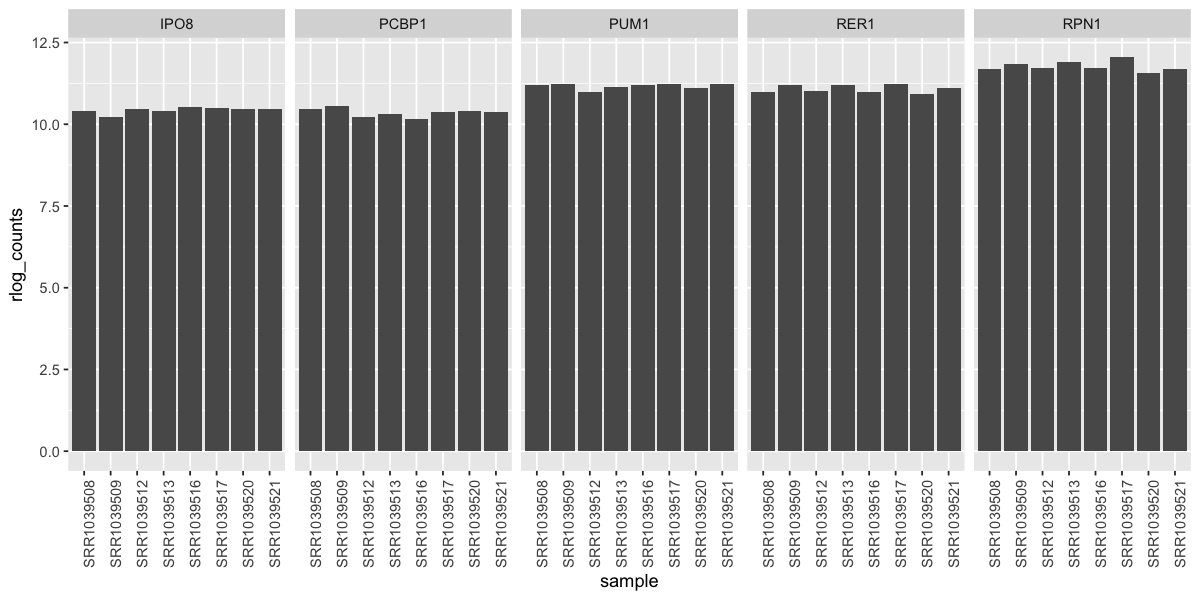

In [59]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(housekeeping_rld_tidy, aes(x=sample, y=rlog_counts)) + 
geom_bar(stat="identity") +
facet_wrap(~hgnc_symbol, nrow = 1) +
theme(axis.text.x = element_text(angle = 90))

These housekeeping genes look stably expressed across each sample.

Now you should have a handle on how to explore your RNAseq experiments. You can use the information you glean from these exploratory analyes to tweak your filtering or other upstream parameters before moving on with further analyses. Please join our Q&A session on Friday, February 5th 2021 from 3-4:00 PM to discuss the workshop and ask any questions you have about the material. 
Thank you!

# Exercises

<div class="alert alert-block alert-success"><b>Exercise 1:</b> Based on what we have just discussed, how would you create a new SummarizedExperiment object that contains information about the genes in the airway data (e.g., the rows) and their location in the genome? What about additional metadata? </div>

In [60]:
airway_counts <- assay(airway)
airway_samples <- colData(airway)
airway_ranges <- rowRanges(airway)
airway_metadata <- metadata(airway)
new_se <- SummarizedExperiment(assays = airway_counts, 
                               colData = airway_samples, 
                               rowRanges = airway_ranges,
                               metadata = airway_metadata)
new_se

class: RangedSummarizedExperiment 
dim: 64102 8 
metadata(1): ''
assays(1): ''
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(9): SampleName cell ... Sample BioSample

<div class="alert alert-block alert-success"><b>Exercise 2:</b> How many genes pass a different filtering cutoff where at least 3 samples must have a count of 10 or higher? How does this filtering change the density plots? </div>

[1] 16596

Warning message:
“Removed 74557 rows containing non-finite values (stat_density).”
Warning message:
“Removed 74554 rows containing non-finite values (stat_density).”


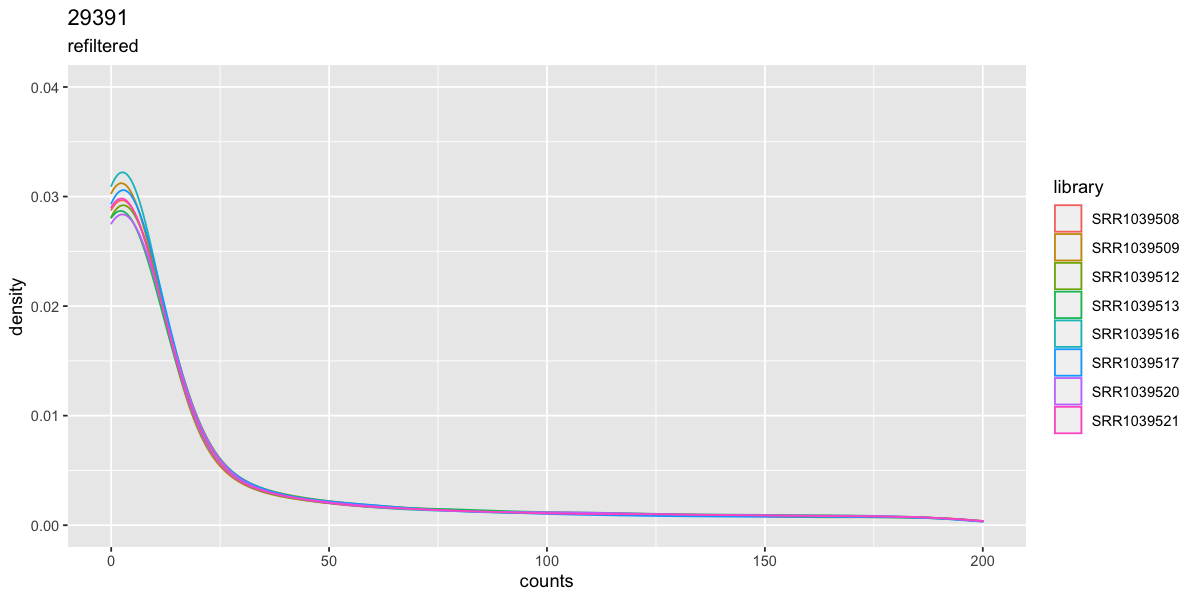

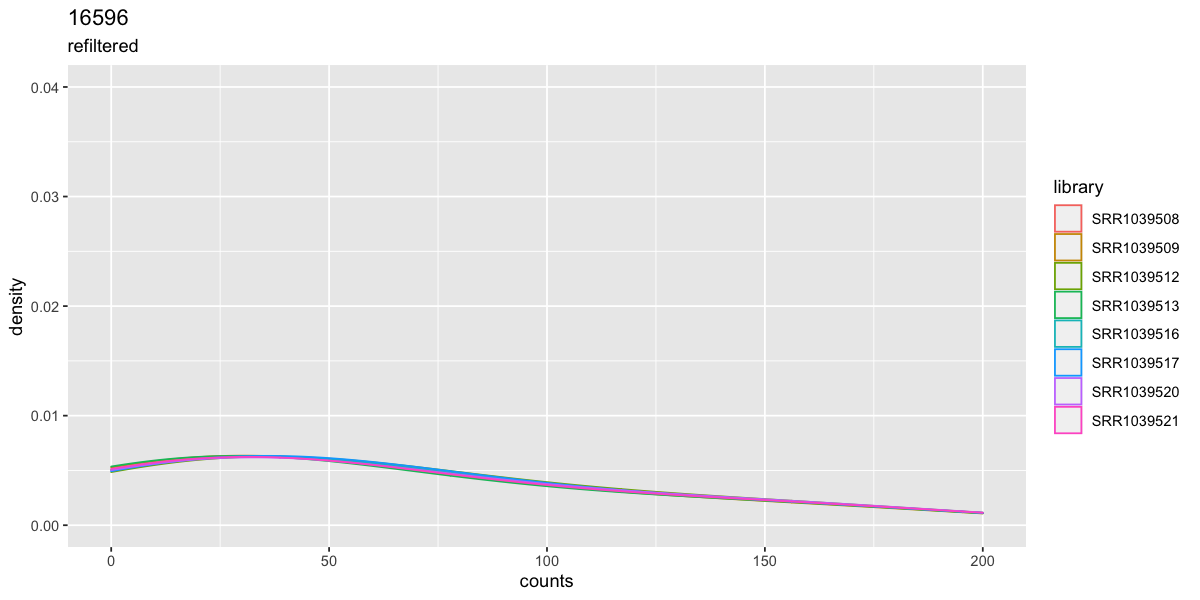

In [61]:
keep <- rowSums(counts(dds) >= 10) >= 3
dds_10 <- dds[keep,]
nrow(dds_10)

counts_melted_10 <- gather(as.data.frame(counts(dds_10)), 
                                 key = 'library', 
                                 value = 'counts', 
                                 SRR1039508:SRR1039521)

options(repr.plot.height=5, repr.plot.width=10)

ggplot(counts_melted_filtered, aes(x = counts)) + 
geom_density(aes(group = library, color = library), adjust = 5) + 
xlim(0, 200) + 
ylim(0, .04) + 
ggtitle(paste0(nrow(dds)), 'refiltered')

ggplot(counts_melted_10, aes(x = counts)) + 
geom_density(aes(group = library, color = library), adjust = 5) + 
xlim(0, 200) + 
ylim(0, .04) + 
ggtitle(paste0(nrow(dds_10)), 'refiltered')

22008 genes are left after filtering. Although this more stringent filtering drops more genes (42094 genes dropped), most of those genes are dropped because their rowsums are less than 1 (34711). The density plots reflect the much lower density of counts near 0.  

<div class="alert alert-block alert-success"><b>Exercise 3:</b> If you look at `?plotPCA`, you'll see that the default behavior of `plotPCA` is to plot the top 500 genes. Does the PCA change if you change those settings and set `ntop = 50`?  </div>


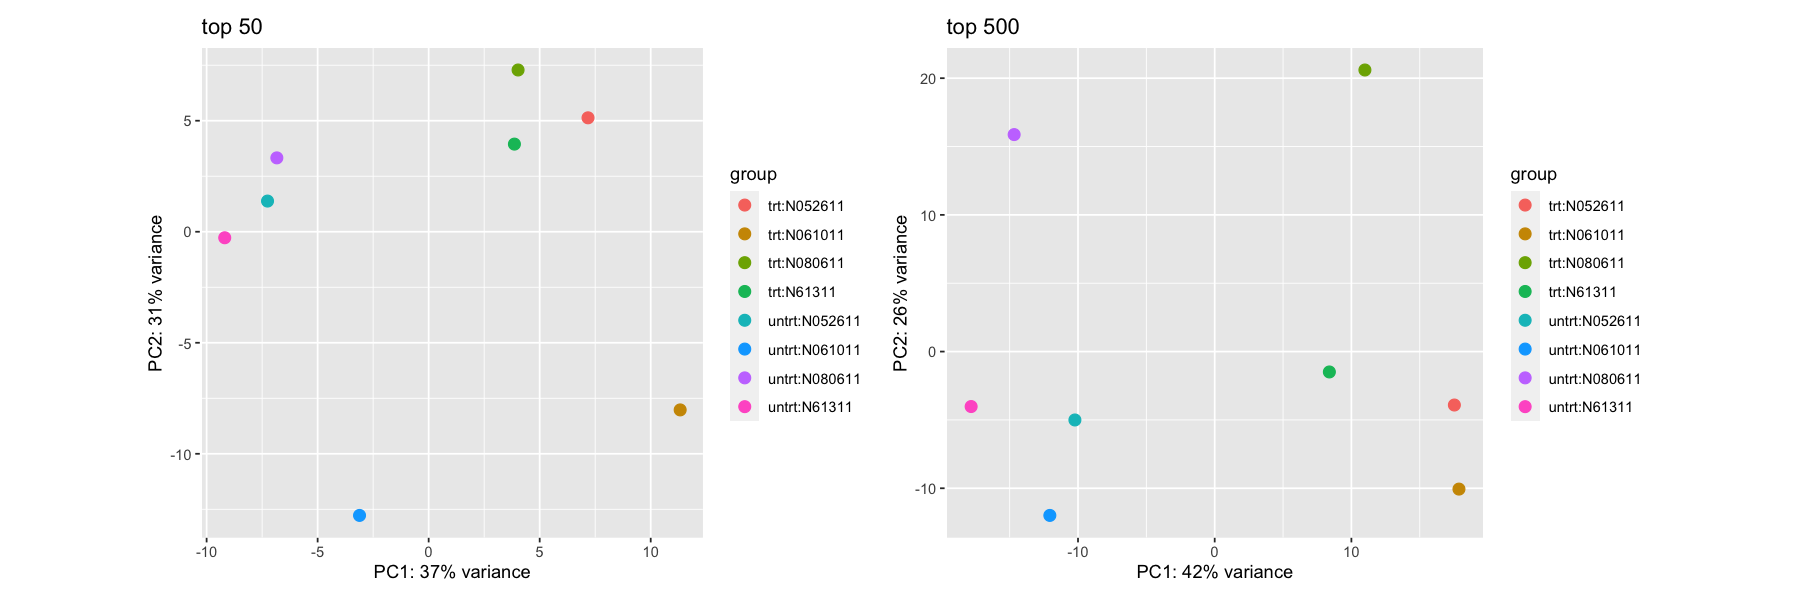

In [64]:
options(repr.plot.height=5, repr.plot.width=15)
plotPCA(rld, intgroup = c("dex", "cell"), ntop = 50) + ggtitle('top 50') |
plotPCA(rld, intgroup = c("dex", "cell"), ntop = 500) + ggtitle('top 500')

By default, plotPCA will base the plot on the 500 genes that explain most of the variance, so you could get plots that make your data look more cleanly separated. This is even more noticeable if you use the top 50 genes instead. This could be misleading and is why you might want to use some other means of plotting your PCA.